# 1. 라이브러리

In [1]:
import re
import itertools

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

from data_analysis.association_pruning import is_associated

/home/container_user/.cache/pypoetry/virtualenvs/hansoldeco3-QckXwucX-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. 목적

타겟을 분석하여 연관된 변수를 찾거나 말뭉치를 만들어 응용하기 위함

# 3. 데이터

In [2]:
train = pd.read_csv("/workspace/Storage/hansoldeco3/Data/raw/train.csv")
target = "재발방지대책 및 향후조치계획"

In [3]:
docs = train[target].to_list()

# 4. 분석

## 4.1 토큰 분석

### 4.1.1 토큰길이

In [4]:
# 베이스라인 토크나이저
model_name = "NCSOFT/Llama-VARCO-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
docs = train[target].to_list()

tokenized_docs = [" ".join(tokenizer.tokenize(doc)) for doc in docs]

<Axes: ylabel='Frequency'>

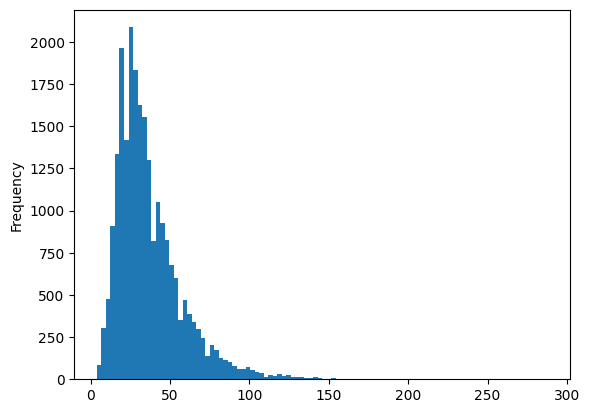

In [6]:
pd.Series([len(x.split(' ')) for x in tokenized_docs]).plot(kind = 'hist', bins =100)

- max token은 100, 넉넉잡아 150으로 해도 될 것 같다.

### 4.1.2 주요 토큰

In [7]:
# 분석용 한국어 GPT-2 토크나이저 로드
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
docs = train[target].to_list()

tokenized_docs = [" ".join(tokenizer.tokenize(doc)) for doc in docs]

#### tf-idf

In [9]:
vectorizer = TfidfVectorizer(smooth_idf=True, sublinear_tf=True)
tfidf_matrix = vectorizer.fit_transform(tokenized_docs)

feature_names = vectorizer.get_feature_names_out()
tfidf_array = tfidf_matrix.toarray()

for i, doc in enumerate(docs):
    print(f"\n📌 문서 {i+1}: {doc}")
    for word, score in zip(feature_names, tfidf_array[i]):
        if score > 0:
            print(f"  {word}: {score:.4f}")
    break


📌 문서 1: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.
  고소: 0.3258
  부위에: 0.5563
  설치: 0.2156
  안전: 0.0915
  위험이: 0.4437
  있는: 0.3646
  작업: 0.0987
  장비: 0.2661
  추락: 0.3454


- 형편없음

#### word cloud

In [10]:
tokenized_docs = [tokenizer.tokenize(s) for s in docs]

text = '\n'.join(docs)
wordcloud = WordCloud().generate(text)
wordcloud.words_

{'재발 방지': 1.0,
 '방지 대책': 0.6597450387698778,
 '통한 재발': 0.5137337363648311,
 '조치 계획': 0.46379287685635434,
 '향후 조치': 0.422000262846629,
 '작업 전': 0.3564200289131292,
 '교육 실시': 0.3464318570114338,
 '안전교육 실시': 0.32763832303850704,
 '작업 시': 0.24957287422788801,
 '방지를 위한': 0.2172427388618741,
 '방지 대책과': 0.21316861611249835,
 '실시를 통한': 0.2092259166776186,
 '안전교육 실시와': 0.19779208831646733,
 '작업자 안전교육': 0.18241556052043634,
 '대책과 향후': 0.16979892232882113,
 '안전 교육': 0.16953607569982915,
 '대책 마련': 0.16677618609541334,
 '실시 및': 0.1575765540806939,
 '대책 및': 0.1499540018399264,
 '교육 및': 0.14890261532395846,
 '안전교육 및': 0.14482849257458272,
 '및 향후': 0.1422000262846629,
 '교육 실시와': 0.13799448022079117,
 '근로자 안전교육': 0.13365751084242344,
 '등': 0.10724142462872914,
 '확인 및': 0.1047443816533053,
 '재발 방지를': 0.10382441845183335,
 '전파 및': 0.10251018530687343,
 '예방을 위한': 0.09975029570245762,
 '안전교육 실시를': 0.09948744907346563,
 '강화를 통한': 0.0985674858719937,
 '안전교육 철저': 0.09633328952556183,
 '대한 재발': 0.095281903009

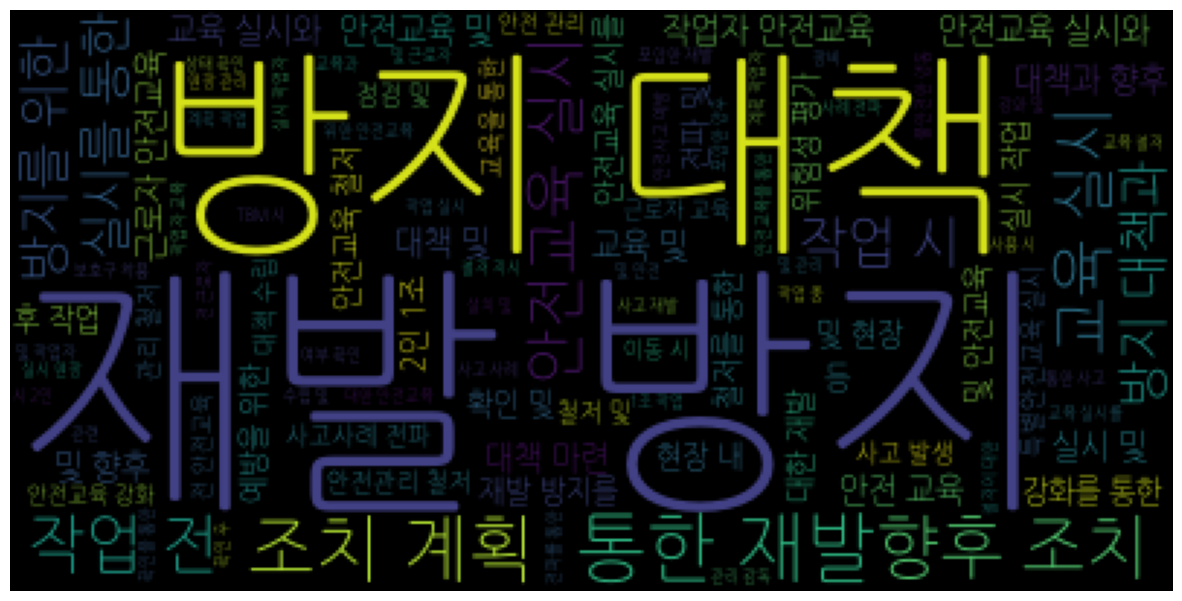

In [11]:
wordcloud = WordCloud(max_words=100,
                      font_path='./NanumGothicLight.otf',
                      stopwords=STOPWORDS).generate(text) # 'said' 사라짐
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- 형편없음

#### 직접하기

In [12]:
train[target].map(lambda x: True if '교육' in x else False).sum()

18007

In [13]:
train[target].map(lambda x: True if '설치' in x else False).sum()

2746

In [14]:
train[target].map(lambda x: True if '보호구' in x else False).sum()

1136

In [15]:
train[target].map(lambda x: True if '정리' in x else False).sum()

1934

In [16]:
train[target].map(lambda x: x[-1]).value_counts()

재발방지대책 및 향후조치계획
.    22997
시      307
행       21
)       17
청       12
치        8
화        7
도        4
획        4
인        3
립        3
정        3
구        3
력        2
성        2
리        2
파        2
련        2
고        2
수        2
토        1
거        1
육        1
법        1
책        1
달        1
철        1
하        1
방        1
운        1
개        1
저        1
내        1
급        1
전        1
레        1
비        1
취        1
장        1
Name: count, dtype: int64

In [17]:
def extract_punctuated_words(text: str):
    words = text.split()  # 공백 기준으로 어절 분리
    extracted_words = []
    
    for i, word in enumerate(words):
        if i == len(words):
            word = words[i - 1] + " " + word
            if ('계획' in word or '실행' in word or '실시' in word or '조치' in word or '대책' in word or '철저' in word) and i > 0:
                word = words[i - 2] + " " + word

            extracted_words.append(word)
            continue
        if ',' in word or '.' in word or ' 및' in word or '와' in word:
            word = words[i - 1] + " " + word
            # '계획', '실행', '실시', '조치'가 포함된 경우, 이전 어절까지 추가
            if ('계획' in word or '실행' in word or '실시' in word or '조치' in word or '대책' in word or '철저' in word) and i > 0:
                word = words[i - 2] + " " + word
            
            # '및', '와' 제거
            word = word.replace('및', "").replace('와', "")
            extracted_words.append(word)
    return extracted_words

def remove_non_korean(text):
    """한글과 공백만 남기는 함수"""
    return re.sub(r'[^가-힣\s]', '', str(text)).strip()

train['analysis_1'] = train[target].map(lambda x: list(filter(lambda x: x, [remove_non_korean(x) for x in extract_punctuated_words(x)])))

In [18]:
train['analysis_1'].head()

0                                       [안전장비 설치]
1                                   [마련과 안전교육 실시]
2                             [현장자재 정리, 향후 조치 계획]
3    [근로자에게 전파하고, 안전교육을 강화하며, 본 사고, 안전교육을 실시할 계획]
4                            [대한 교육 실시, 정리 작업 실시]
Name: analysis_1, dtype: object

In [19]:
l = list(itertools.chain.from_iterable(train['analysis_1']))

In [20]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

In [22]:
sentence_embeddings = model.encode(l, convert_to_numpy=True)

In [23]:
# 4️⃣ KMeans 군집화 (최적 K는 실험 필요)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(sentence_embeddings)

In [26]:
# 5️⃣ 각 군집의 대표 문장 찾기
def find_representative_sentences(embeddings, labels, sentences):
    cluster_centers = kmeans.cluster_centers_  # 군집 중심 좌표
    representatives = []

    for cluster_idx in range(num_clusters):
        cluster_points = np.where(labels == cluster_idx)[0]
        if len(cluster_points) <= 1:  # **혼자 있는 샘플(노이즈) 제거**
            continue
        
        # 중심과 가장 가까운 문장 찾기
        distances = np.linalg.norm(embeddings[cluster_points] - cluster_centers[cluster_idx], axis=1)
        closest_index = cluster_points[np.argmin(distances)]
        representatives.append(sentences[closest_index])

    return representatives

representative_sentences = find_representative_sentences(sentence_embeddings, labels, l)

In [27]:
representative_sentences

['재발 방지 대책',
 '대한 안전교육 실시',
 '향후 조치 계획',
 '발생을 예방하는 조치',
 '작업 실시',
 '교육 실시',
 '완충재 깔기',
 '관리 감독 철저',
 '확인 계획',
 '안전조치 확인 철저']

- 별 의미를 못찾았는데, 차라리 전체 센텐스 의미로 군집하는게 좋을 것 같다.

In [72]:
def split_sentence(s):
    a = s.split('.')
    b = []
    for i in a:
        b.append(i.split(','))
    c=list(filter(lambda x: x, itertools.chain.from_iterable(b)))
    return c

In [77]:
from sentence_transformers import SentenceTransformer

t = train[target].map(split_sentence)
t = list(itertools.chain.from_iterable(t))

model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

sentence_embeddings = model.encode(t, convert_to_numpy=True)

# 4️⃣ KMeans 군집화 (최적 K는 실험 필요)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(sentence_embeddings)


representative_sentences = find_representative_sentences(sentence_embeddings, labels, t)

In [78]:
representative_sentences

['작업자 안전교육 실시와 작업 전 위험요소 점검 강화',
 '근로자 안전교육 실시와 작업공구 이상유무 점검 철저를 통한 사고사례 전파 및 안전교육 시행',
 '작업 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획',
 '개인보호구 안전벨트 조임줄 정리와 수평 유지 철근 관리 철저를 통한 재발 방지 대책 및 개인보호장구 착용 방식 철저와 이음철근 관리 철저를 포함한 향후 조치 계획',
 '작업장 이동로 정리정돈 실시와 건설사업관리용역사 및 시공사의 안전관리 철저 지시',
 '카고크레인 상부 작업 시 2인 1조 배치와 자재 양중 시 근로자 이동 금지 등의 특별 안전교육 실시와 관리자 및 작업자 대상 안전교육 철저',
 '상수관과 측벽 사이의 공간 확보로 소형 굴착기를 이용한 슬러지 제거 작업 시행과 인력 작업 시 주형보 브레이싱에 안전벨트 걸이 시설 설치 및 추락 방지 안전벨트 체결 후 작업 시행',
 '작업 전 TBM을 통하여 위험요인을 사전에 인지하고 보안경과 같은 안면보호구를 사용하여 재해 예방 및 10월 27일 강남에 위치한 서울아산병원에서 재진료를 받은 후 요양급여 신청 준비 중인 상황',
 '작업자 안전교육 실시와 절곡기 상부에 위험/안전존 표식 부착을 통한 재발 방지 대책 및 철근가공과 조립작업에 대한 안전교육 실시와 철근가공기 사용 숙련도 확인을 포함한 향후 조치 계획',
 '안전교육 철저 및 사고방지 대책 수립']

<Axes: ylabel='Frequency'>

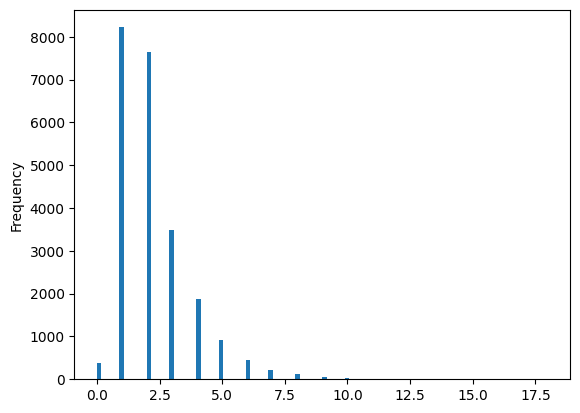

In [65]:
train['analysis_1'].map(len).plot(kind='hist', bins=100)

## 4.2 품사태깅

In [8]:
okt = Okt()

tagged_docs = []
for doc in docs:
    tagged_doc = okt.pos(doc)
    tagged_docs.append(tagged_doc)
tagged_docs[0]

[('고소', 'Noun'),
 ('작업', 'Noun'),
 ('시', 'Noun'),
 ('추락', 'Noun'),
 ('위험', 'Noun'),
 ('이', 'Josa'),
 ('있는', 'Adjective'),
 ('부위', 'Noun'),
 ('에', 'Josa'),
 ('안전', 'Noun'),
 ('장비', 'Noun'),
 ('설치', 'Noun'),
 ('.', 'Punctuation')]

- 형편없음

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# 1️⃣ 사전 학습된 한국어 BERT 모델 로드
model_name = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# 2️⃣ NLP 태깅 파이프라인 설정
nlp_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

tagged_docs = []
for doc in docs:
    tagged_doc = nlp_pipeline(doc)
    tagged_docs.append(tagged_doc)


# 결과